# Integrantes

- Sergio Orellana 221122
- Rodrigo Mansilla 22611
- Carlos Valladares 221164

# Ejercicio 1

## Simulación de tiempo discreto (síncrona) vs. tiempo continuo (asíncrona)

- **Tiempo discreto (síncrona)**: yo actualizo el estado del sistema en pasos fijos (ticks) con un reloj global, de modo que todos los componentes se actualizan “a la vez” en cada paso. Esto es análogo a trabajar con señales muestreadas y diferencia-ecuaciones en control digital. 

- **Tiempo continuo (asíncrona)**: yo permito cambios en cualquier instante real; típicamente lo implemento como simulación dirigida por eventos que “salta” al próximo evento en una cola de eventos, sin pasos fijos. (En marcos como SimPy, los procesos se programan con env.timeout y el motor avanza al siguiente evento).

**(a) ¿Cuándo prefiero cada una?**
Prefiero tiempo discreto (síncrona) cuando:
- El fenómeno ya está muestreado por naturaleza (p. ej., control digital, DSP, comunicaciones digitales). 
- Necesito simplicidad y determinismo (flujo secuencial más fácil de razonar y depurar). 

Prefiero tiempo continuo (asíncrona) cuando:
- El timing exacto de los sucesos importa (colas/redes, tráfico, servicios), porque el motor salta entre eventos sin simular “tiempo vacío”. 
- Busco escala y capacidad de respuesta en sistemas dirigidos por eventos o procesamiento asíncrono. 

**(b) Compensaciones computacionales (velocidad vs. precisión)**
- **Discreto/síncrona:** suele ser más rápida por implementación y más simple de depurar, pero su precisión depende del tamaño del paso (riesgo de aliasing/artefactos si el paso es grande). 
- **Continuo/asíncrona:** logra mejor precisión temporal (eventos en el instante exacto) y puede ser eficiente al evitar pasos donde nada ocurre; a cambio, incrementa la complejidad (concurrencia, manejo de callbacks/eventos, depuración).

## Mecanismos de gestión de eventos
**(a) ¿Cómo gestionan los cambios de estado las colas de eventos?**

Cuando modelo de forma asíncrona, mantengo una cola de eventos con elementos del tipo (tiempo, tipo, datos). El ciclo de simulación hace:

- Extraer el siguiente evento (el de menor marca de tiempo).
- Avanzar el reloj de simulación a ese instante.
- Aplicar las transiciones de estado y programar nuevos eventos (insertarlos en la cola).

Este patrón aparece tanto en frameworks de simulación (p. ej., SimPy con procesos/env.timeout) como en bucles de eventos (JS: el event loop despacha tareas desde la event queue cuando la pila está libre). 

En arquitectura de sistemas, las message queues/colas de mensajes permiten desacoplar productores y consumidores de eventos, reforzando la idea de que los cambios de estado se encolan y se procesan sin bloquear el flujo principal

**(b) Gestión de prioridades para eventos concurrentes**

Para resolver eventos “al mismo tiempo” o con diferentes importancias, utilizo una cola de prioridad (típicamente un binary heap), donde sale primero el evento de mayor prioridad (o menor tiempo y, si hay empates, un criterio secundario). Las operaciones de insertar y extraer tienen costo O(log n), lo que mantiene eficiente el motor de simulación. Además, las simulaciones dirigidas por eventos son un caso de uso clásico de colas de prioridad. 

Como ejemplo de priorización de colas en un bucle de eventos, en JavaScript existen microtareas que se procesan antes de las tareas normales, mostrando cómo la política de prioridad afecta qué se ejecuta primero cuando hay concurrencia.



R_eff (discreto): 2.706
R_eff (eventos):  2.000


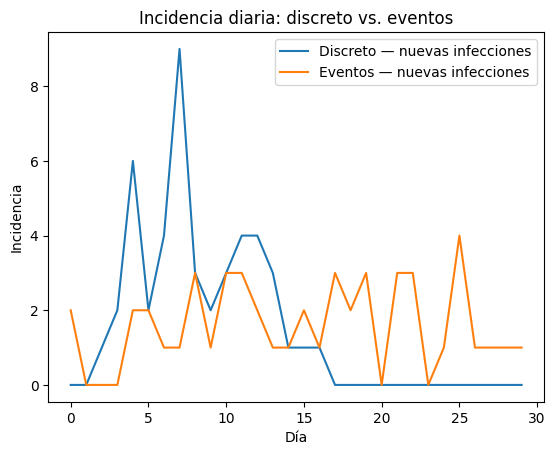

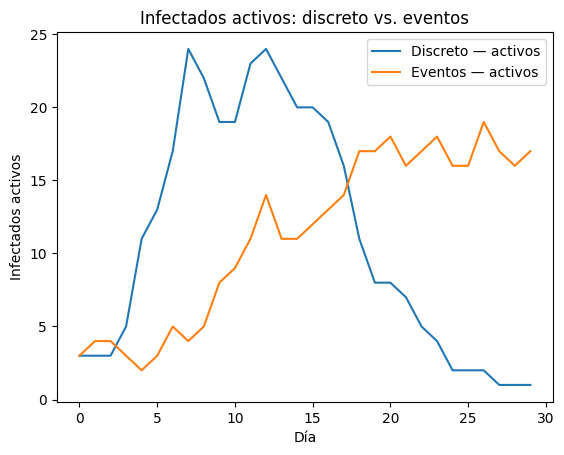

In [1]:
import math
import random
import heapq
from dataclasses import dataclass
from typing import Optional, List, Dict, Tuple

import pandas as pd
import matplotlib.pyplot as plt

# Utilidades

def poisson_knuth(lam: float) -> int:
    """Muestreo de Poisson con el algoritmo de Knuth (adecuado para lambda pequeña-media)."""
    if lam <= 0:
        return 0
    L = math.exp(-lam)
    k = 0
    p = 1.0
    while p > L:
        k += 1
        p *= random.random()
    return k - 1

def expovariate_safe(rate: float) -> float:
    """Devuelve tiempo de espera exponencial con media 1/rate; maneja rate=0."""
    if rate <= 0:
        return float('inf')
    return random.expovariate(rate)

# Dominio
@dataclass
class Agent:
    id: int
    role: str            # 'patient' o 'staff'
    ward: int            # sala (0,1, ...)
    state: str = 'S'     # 'S','I','R'
    infected_by: Optional[int] = None
    inf_time: Optional[float] = None
    rec_time: Optional[float] = None
    mask: float = 0.6     # [0,1] (1 = máxima adherencia)
    hygiene: float = 0.6  # [0,1]
    immunity: float = 0.0 # [0,1] (1 = completamente inmune)

class Params:
    """
    Parámetros del hospital y de la enfermedad.
    """
    def __init__(self):
        # Estructura
        self.wards = [0, 1]     # dos salas
        self.n_patients = 50
        self.n_staff = 10

        # Enfermedad
        self.beta = 0.06              # prob. base de transmisión por contacto
        self.mask_eff = 0.35          # reducción fraccional por uso de mascarilla (por cada lado)
        self.hygiene_eff = 0.25       # reducción fraccional por higiene promedio
        self.inf_mean_days = 7.0      # duración media infecciosa (días)

        # Contactos esperados por día
        self.c_rate_patient = 6.0
        self.c_rate_staff = 12.0

        # Movimiento entre salas
        self.move_rate_per_day = 0.02

        # Discreto
        self.days = 30

        # Dirigido por eventos
        self.horizon_days = 30.0
        self.max_events = 100_000

def transmission_prob(p: Params, a: Agent, b: Agent) -> float:
    """
    Probabilidad efectiva de transmisión en un contacto a->b.
    Incluye efectos de mascarilla, higiene e inmunidad (susceptibilidad).
    """
    mask_mult = (1 - p.mask_eff * a.mask) * (1 - p.mask_eff * b.mask)
    hygiene_mult = 1 - p.hygiene_eff * (a.hygiene + b.hygiene) / 2.0
    susceptibility_mult = 1 - b.immunity
    pr = p.beta * mask_mult * hygiene_mult * susceptibility_mult
    return max(0.0, min(1.0, pr))

def sample_infectious_duration(p: Params) -> float:
    """Muestra una duración infecciosa ~ Exponencial(media = p.inf_mean_days)."""
    return random.expovariate(1.0 / p.inf_mean_days)

def init_agents(p: Params, rng_seed: Optional[int] = None) -> List[Agent]:
    """
    Inicializa pacientes y personal con heterogeneidad en adherencia e inmunidad.
    Si rng_seed no es None, siembra aleatoriedad para reproducibilidad.
    """
    if rng_seed is not None:
        random.seed(rng_seed)

    agents: List[Agent] = []

    # Pacientes
    for i in range(p.n_patients):
        agents.append(Agent(
            id=i,
            role='patient',
            ward=random.choice(p.wards),
            mask=min(1.0, max(0.0, random.gauss(0.6, 0.15))),
            hygiene=min(1.0, max(0.0, random.gauss(0.6, 0.15))),
            immunity=max(0.0, random.gauss(0.05, 0.05)),
        ))

    # Personal
    for j in range(p.n_staff):
        agents.append(Agent(
            id=p.n_patients + j,
            role='staff',
            ward=random.choice(p.wards),
            mask=min(1.0, max(0.0, random.gauss(0.8, 0.10))),
            hygiene=min(1.0, max(0.0, random.gauss(0.8, 0.10))),
            immunity=max(0.0, random.gauss(0.10, 0.05)),
        ))

    # Semilla de infecciones iniciales
    seed_ids = random.sample(range(len(agents)), k=3)
    for sid in seed_ids:
        a = agents[sid]
        a.state = 'I'
        a.inf_time = 0.0
        a.rec_time = sample_infectious_duration(p)

    return agents

# Arquitectura 1: tiempo discreto

def run_discrete(p: Params, seed: int = 123) -> Tuple[pd.DataFrame, Dict[int, int]]:
    random.seed(seed)
    agents = init_agents(p)
    offspring = {a.id: 0 for a in agents}  # número de secundarios por infectante

    daily_incidence: List[int] = []
    daily_active: List[int] = []

    for day in range(p.days):
        new_inf = 0

        # Recuperaciones al inicio del día
        for a in agents:
            if a.state == 'I' and a.rec_time is not None and a.rec_time <= day:
                a.state = 'R'

        # Índice por sala
        ward_index: Dict[int, List[Agent]] = {w: [] for w in p.wards}
        for a in agents:
            ward_index[a.ward].append(a)

        # Contactos
        for a in agents:
            lam = p.c_rate_patient if a.role == 'patient' else p.c_rate_staff
            k = poisson_knuth(lam)
            if k <= 0:
                continue

            peers = ward_index[a.ward]
            if len(peers) <= 1:
                continue

            for _ in range(k):
                b = random.choice(peers)
                if b.id == a.id:
                    continue

                # Intentar transmisión en ambos sentidos
                if a.state == 'I' and b.state == 'S':
                    pr = transmission_prob(p, a, b)
                    if random.random() < pr:
                        b.state = 'I'
                        b.inf_time = float(day)
                        b.rec_time = day + sample_infectious_duration(p)
                        b.infected_by = a.id
                        offspring[a.id] += 1
                        new_inf += 1

                elif b.state == 'I' and a.state == 'S':
                    pr = transmission_prob(p, b, a)
                    if random.random() < pr:
                        a.state = 'I'
                        a.inf_time = float(day)
                        a.rec_time = day + sample_infectious_duration(p)
                        a.infected_by = b.id
                        offspring[b.id] += 1
                        new_inf += 1

        # Movimiento
        for a in agents:
            if random.random() < p.move_rate_per_day:
                a.ward = 1 - a.ward

        # Métricas
        active = sum(1 for a in agents if a.state == 'I')
        daily_incidence.append(new_inf)
        daily_active.append(active)

    total_secondary = sum(offspring.values())
    n_infectors = sum(1 for x in offspring.values() if x > 0)
    r_eff = total_secondary / max(1, n_infectors)

    df = pd.DataFrame({
        "day": list(range(p.days)),
        "new_infections": daily_incidence,
        "active_infected": daily_active
    })
    df.attrs["R_eff_estimate"] = r_eff
    return df, offspring

# Arquitectura 2: dirigida por eventos
def run_event_driven(p: Params, seed: int = 456) -> Tuple[pd.DataFrame, Dict[int, int]]:
    random.seed(seed)
    agents = init_agents(p)
    offspring = {a.id: 0 for a in agents}

    # Cola de eventos: (time, seq, type, agent_id, payload)
    q: List[Tuple[float, int, str, int, dict]] = []
    seq = 0

    def schedule(time: float, typ: str, aid: int, payload: dict = None):
        nonlocal seq
        heapq.heappush(q, (time, seq, typ, aid, payload or {}))
        seq += 1

    def contact_rate(a: Agent) -> float:
        return p.c_rate_patient if a.role == 'patient' else p.c_rate_staff

    # Inicialización: primer contacto y movimiento de cada agente; recuperaciones para infectados
    for a in agents:
        schedule(expovariate_safe(contact_rate(a)), "contact", a.id)
        schedule(expovariate_safe(p.move_rate_per_day), "move", a.id)
        if a.state == 'I':
            schedule(sample_infectious_duration(p), "recovery", a.id)

    infection_times: List[float] = []
    recovery_times: List[float] = []

    events_processed = 0
    while q and events_processed < p.max_events:
        t, _, typ, aid, payload = heapq.heappop(q)
        if t > p.horizon_days:
            break
        a = agents[aid]

        if typ == "contact":
            # Reprogramar siguiente contacto de este agente
            schedule(t + expovariate_safe(contact_rate(a)), "contact", a.id)

            # Elegir contraparte en la misma sala
            peers = [x for x in agents if x.ward == a.ward and x.id != a.id]
            if peers:
                b = random.choice(peers)

                # Intentar transmisión en ambos sentidos
                def try_transmit(src: Agent, dst: Agent):
                    nonlocal infection_times
                    if src.state == 'I' and dst.state == 'S':
                        pr = transmission_prob(p, src, dst)
                        if random.random() < pr:
                            dst.state = 'I'
                            dst.inf_time = t
                            dur = sample_infectious_duration(p)
                            dst.rec_time = t + dur
                            dst.infected_by = src.id
                            offspring[src.id] += 1
                            infection_times.append(t)
                            # Programar recuperación del nuevo infectado
                            schedule(dst.rec_time, "recovery", dst.id)

                try_transmit(a, b)
                try_transmit(b, a)

        elif typ == "recovery":
            if a.state == 'I':
                a.state = 'R'
                a.rec_time = t
                recovery_times.append(t)

        elif typ == "move":
            # Cambio de sala y reprogramación del próximo movimiento
            a.ward = 1 - a.ward
            schedule(t + expovariate_safe(p.move_rate_per_day), "move", a.id)

        events_processed += 1

    # Agregación diaria de métricas 
    days = int(math.ceil(p.horizon_days))
    daily_incidence: List[int] = [0] * days
    for it in infection_times:
        d = int(math.floor(it))
        if 0 <= d < days:
            daily_incidence[d] += 1

    daily_active: List[int] = []
    for d in range(days):
        cnt = 0
        for ag in agents:
            if ag.inf_time is not None and ag.inf_time <= d:
                # Si rec_time es None o mayor al día actual, sigue activo
                if ag.rec_time is None or d < ag.rec_time:
                    cnt += 1
        daily_active.append(cnt)

    total_secondary = sum(offspring.values())
    n_infectors = sum(1 for v in offspring.values() if v > 0)
    r_eff = total_secondary / max(1, n_infectors)

    df = pd.DataFrame({
        "day": list(range(days)),
        "new_infections": daily_incidence,
        "active_infected": daily_active
    })
    df.attrs["R_eff_estimate"] = r_eff
    return df, offspring

if __name__ == "__main__":
    random.seed(42)

    p = Params()
    df_disc, off_disc = run_discrete(p, seed=101)
    df_ev, off_ev = run_event_driven(p, seed=202)

    print(f"R_eff (discreto): {df_disc.attrs.get('R_eff_estimate'):.3f}")
    print(f"R_eff (eventos):  {df_ev.attrs.get('R_eff_estimate'):.3f}")

    # Incidencia diaria
    plt.figure()
    plt.plot(df_disc["day"], df_disc["new_infections"], label="Discreto — nuevas infecciones")
    plt.plot(df_ev["day"], df_ev["new_infections"], label="Eventos — nuevas infecciones")
    plt.xlabel("Día")
    plt.ylabel("Incidencia")
    plt.title("Incidencia diaria: discreto vs. eventos")
    plt.legend()
    plt.show()

    # Activos diarios
    plt.figure()
    plt.plot(df_disc["day"], df_disc["active_infected"], label="Discreto — activos")
    plt.plot(df_ev["day"], df_ev["active_infected"], label="Eventos — activos")
    plt.xlabel("Día")
    plt.ylabel("Infectados activos")
    plt.title("Infectados activos: discreto vs. eventos")
    plt.legend()
    plt.show()


## Especificación (discreto)

**Reloj:** `d = 0, 1, 2, ...` (días)

**Ciclo por día:**
1. Procesar recuperaciones (`rec_time <= d`).
2. Construir índice de sala → lista de agentes.
3. Para cada agente, muestrear `#contactos ~ Poisson(c_rate_role)`.
   - Para cada contacto, elegir un par aleatorio en la misma sala y evaluar transmisión en ambos sentidos.
4. Aplicar movimiento (con probabilidad pequeña por día).
5. Medir métricas: nuevas infecciones del día e infectados activos.

**Eventos a monitorizar (implícitos por paso):**
- Contacto (potencial contagio)
- Recuperación
- Movimiento

**Métricas de salida:**
- Incidencia diaria
- Activos diarios
- R_eff (crudo)
- Descendencia por agente (número de secundarios por infectante)

## Especificación (dirigida por eventos)

**Reloj:** tiempo continuo; el simulador **salta** al tiempo del **siguiente evento**.

**Estructura de eventos:** cola de prioridad (*heap*) con tuplas  
`(time, seq, type, agent_id, payload)`.

**Tipos de eventos:**
- `contact`: un agente tiene contacto; se elige una contraparte en la misma sala y se intenta transmisión en ambos sentidos.  
  Se programa el próximo contacto del agente con espera `~ Expon(rate_contacto)`.
- `recovery`: un infectado pasa a `R`.
- `move`: cambio de sala; se reprograma el próximo movimiento `~ Expon(move_rate)`.

**Métricas de salida:**
- A partir de las marcas temporales de infecciones:
  - Incidencia diaria agregada
  - Activos diarios (conteo entre `inf_time` y `rec_time`)
  - R_eff
  - Descendencia por agente


# Teoría — Taxonomía de rasgos y espacio de parámetros (formato ipynb, en primera persona)

## 1) Clasificación de rasgos (discreto, continuo o relacional)

- **a) Edad → _continuo_ (escala de razón)**  
  Yo la trato como una cantidad medible sobre tiempo real; aunque a veces la discretice (en años), su naturaleza es continua. 

- **b) Profesión → _discreto_ (categórico nominal)**  
  Yo la represento como una categoría sin orden intrínseco (médico, enfermero, administrativo, etc.). 

- **c) Redes de amistad → _relacional_**  
  Yo las modelo como relaciones (aristas) entre agentes (nodos) en un grafo/social network; no es un atributo individual, sino una estructura de vínculos. 

- **d) Estado de vacunación → _discreto_ (binario/dicotómico)**  
  Yo lo codifico como variable dicotómica (vacunado / no vacunado), un caso de variable nominal con dos niveles. 


## 2) Tamaño del espacio de parámetros y efecto en el tiempo de ejecución

**Escenario:** 10 000 agentes con **3 rasgos continuos** (p. ej., tasas) y **2 rasgos discretos** (p. ej., ocupación).

### 2.1. Tamaño del espacio

- Si dejo los continuos como reales, el espacio **por agente** es **infinito**. Para poder explorarlo, yo **discretizo** cada continuo en $k$ “bins” (resolución). Con $d_1, d_2$ categorías para los dos rasgos discretos, el tamaño queda:

$$
|\Omega_{\mathrm{agente}}| \;=\; k^3 \, d_1 \, d_2
$$

$$
|\Omega_{\mathrm{total}}| \;=\; \big(k^3 \, d_1 \, d_2\big)^{10{,}000}
$$

- Este crecimiento por producto es **combinatorio** y se conecta con la **maldición de la dimensionalidad**: al aumentar dimensiones (parámetros) y resolución ($k$), la cantidad de configuraciones y muestras necesarias explota.

> **Ejemplo (ilustrativo):** si $k=100$, $d_1=10$ (ocupaciones) y $d_2=2$ (binario), entonces  
> $|\Omega_{\mathrm{agente}}| = 100^3 \cdot 10 \cdot 2 = 20{,}000{,}000$ y  
> $|\Omega_{\mathrm{total}}| = (2\times10^7)^{10{,}000}$ (astronómico).

### 2.2. Efecto en el tiempo de ejecución

- Cuando hago un **grid search** (barrido exhaustivo), el número de combinaciones escala como el **producto** de opciones por parámetro; con los continuos discretizados, yo evalúo aproximadamente
$$
N_{\mathrm{corridas}} \;=\; k^3 \, d_1 \, d_2,
$$
y cada combinación suele requerir varias corridas/semillas. 

- El tiempo total de cómputo crece como $N_{\mathrm{corridas}} \times T_{\mathrm{sim}}$; aunque $T_{\mathrm{sim}}$ sea moderado, el gran $N_{\mathrm{corridas}}$ produce explosión combinatoria (otra manifestación de la maldición de la dimensionalidad). 

- **Cómo lo mitigo en la práctica:** en vez de barridos exhaustivos, uso muestreos estratificados como **Latin Hypercube Sampling (LHS)** para cubrir el espacio con muchas menos corridas manteniendo buena cobertura. 




### Pseudocódigo

In [ ]:
class Agent:
    def __init__(self, id):
        self.id = id

        # --- Rasgos discretos ---
        self.age_group = choice(["0-18", "19-65", "65+"])          # edad categórica
        self.occupation = choice(["healthcare", "education", "other"])  # ocupación
        self.vaccinated = choice([True, False], p=[0.6, 0.4])      # estado de vacunación

        # --- Rasgos continuos ---
        self.mobility = sample_gamma(shape=2, scale=1.5)   # contactos/día, Gamma
        self.income = sample_lognormal(mu=10, sigma=0.5)   # ingreso aproximado

        # --- Rasgo relacional ---
        self.household_id = assign_household_id()

# Nota: healthcare y education se "encodean" como categorías distintas, no como un booleano;
# así evitamos que "maestros" queden diluidos dentro de "otros" y se pueda introducir sesgo.
# -> Es decir, codificar ocupaciones clave en categorías explícitas.

# ========== Paso 2: Métodos de muestreo ==========
def generate_population(N):
    agents = []
    for i in range(N):
        agents.append(Agent(i))
    return agents

# Distribuciones realistas:
# - Edad: distribución empírica basada en censos
# - Movilidad: Gamma (asimétrica, con pocos muy móviles)
# - Ingreso: Lognormal
# - Turnos de enfermeras: Bernoulli(p=0.2) dentro de ocupación 'healthcare'

def validate_shift_distribution(pop):
    nurses = [a for a in pop if a.occupation == "healthcare"]
    night_shifts = [n for n in nurses if n.shift == "night"]
    observed_prop = len(night_shifts) / len(nurses)
    assert abs(observed_prop - 0.20) < tolerance  # validar que ≈20% cumplen

# ========== Paso 3: Correlaciones entre rasgos ==========
# Hipótesis:
# - Bajos ingresos correlacionan con menor acceso a vacunas.
# - Esto genera clusters de alta vulnerabilidad (muchos susceptibles juntos).
# - Efecto: brotes más intensos y prolongados en subpoblaciones marginalizadas.

def simulate_outbreak(pop):
    # Agrupar agentes por (income_level, vaccinated)
    # Calcular riesgo relativo de infección
    # Predecir mayor R0 efectivo en clústeres de "bajo ingreso + no vacunados"
    pass


# Ejercicio 3

## 1) Teoría — Interacción entre modelo temporal y rasgos

### 1. Considere un escenario de una ciudad con:  
    a. Modelo temporal: Tiempo continuo (infecciones impulsadas por eventos)  
    b. Distribución de rasgos: 20% mayores (alto riesgo), 30% trabajadores esenciales (alta movilidad)  

i. ¿Cómo podría la interacción del modelo temporal y la distribución de rasgos amplificar los brotes en residencias de ancianos?  

En un modelo de tiempo continuo, cada contacto y evento de infección ocurre en el instante exacto.  
Dado que los mayores (20%) concentran un alto riesgo y suelen estar agrupados en residencias:  
    - Un solo evento puede desencadenar múltiples infecciones en pocas horas.  
    - La susceptibilidad elevada y la densidad de contactos amplifican rápidamente los brotes.  
    - El modelo continuo captura la velocidad real de propagación que un modelo discreto no mostraría.  

ii. ¿Podría el modelado de tiempo discreto ocultar esta dinámica? ¿Por qué?  

Sí. El tiempo discreto actualiza en pasos fijos (p. ej., diario).  
Esto puede ocultar cadenas rápidas de contagio porque:  
    - Varias infecciones dentro del mismo intervalo aparecen como un único salto.  
    - Se pierden las diferencias entre contagios ocurridos en minutos/horas distintas.  
    - Se subestima la rapidez de los brotes en entornos vulnerables.  


### 2. Considere curvas de infección con picos repentinos en barrios de bajos ingresos  

    a. Identifique dos objetivos de calibración para validar  
        1. Tiempo de eventos → Medir intervalos de infección y compararlos con datos reales.  
        2. Resultados dependientes de rasgos → Tasas de casos por nivel de ingreso, para comprobar desigualdades.  

    b. ¿Cómo distinguiría entre artefactos del modelo y desigualdades reales?  
        - Si los picos desaparecen al usar mayor resolución temporal → son artefactos del modelo.  
        - Si persisten en diferentes escalas y coinciden con datos externos (movilidad, hacinamiento, acceso desigual) → reflejan desigualdades reales.  



## Ejercicio práctico

Usando lo propuesto de la parte práctica de los ejercicios 1 y 2, realice la propuesta de diseño de la vacunación en
una ciudad diversa con :  
• Grupos prioritarios: Personas mayores de 65 años, personal sanitario y docentes  
• Barreras de acceso: Distancia a las clínicas, reticencia a la vacunación  
• Combinación de tiempo y hetereogeneidad  

Con esto realice lo siguiente:
1. Diseñe reglas de prioridad para la cola de eventos:
   a. Por ejemplo: `if agent.age > 65: schedule_vaccine(priority=1)`  
   b. Responda: ¿Cómo gestionaría los conflictos (p. ej., un docente que también es mayor)?
2. Defina 3 subpoblaciones con:
   a. Rasgos continuos: Puntuación de riesgo (0-10)  
   b. Rasgos discretos: Nivel de acceso (1=alto, 3=bajo)  
   c. Responda: Proponer un método de muestreo para garantizar que los grupos minoritarios no estén
   infrarrepresentados.
3. Diseñe un sistema de registro para rastrear:
   a. Secuencia de eventos (marca de tiempo, ID del agente, estado de la vacuna)  
   b. Asignación de dosis por subpoblación  
   c. Responda: ¿Qué visualización revelaría mejor las disparidades de acceso (p. ej., mapas de calor,
   curvas de Lorenz)?
4. Adicionalmente responda
   a. Cómo las interacciones rasgo-tiempo podrían sesgar las recomendaciones de políticas.

> Nota del enunciado: Al ser la propuesta de diseño, no se espera que corra la simulación en código, solo que deje el
> pseudo código y las especificaciones del mismo. Si hace que ejecute, esto contará como puntos extras.


Respuesta (reglas propuestas):
- Prioridad (menor número = mayor prioridad):  
  1. `age ≥ 65` (alto riesgo por severidad)  
  2. `occupation == 'healthcare'` (alta exposición)  
  3. `occupation == 'education'` (alto número de contactos)  
  4. Resto de la población

- Desempates (en este orden):  
  1. Mayor tiempo de espera desde su elegibilidad (evita inanición en la cola).  
  2. Mayor `risk_score` (0–10).  
  3. Peor `access_level` (1=alto, 3=bajo → favorecer `3` ante empate para mitigar inequidad).

- Estructura de datos recomendada: min-heap con clave compuesta  
  `(priority, -wait_time, -risk_score, access_level, timestamp, agent_id)`.

- Repriorización dinámica: si cambian riesgo, acceso o espera, reinserte con nueva clave.

In [3]:
# PSEUDOCÓDIGO / PLANTILLA PYTHON (no ejecuta simulación real)
from dataclasses import dataclass, field
import heapq
from time import time

@dataclass(order=True)
class QueueItem:
    key: tuple
    agent_id: int = field(compare=False)

@dataclass
class Agent:
    id: int
    age: int
    occupation: str          # {'healthcare','education','other'}
    risk_score: float        # [0,10]
    access_level: int        # 1=alto, 2=medio, 3=bajo
    eligible_since: float    # timestamp (segundos)
    vaccine_status: str = "unvaccinated"

def base_priority(a: Agent) -> int:
    if a.age >= 65: return 1
    if a.occupation == "healthcare": return 2
    if a.occupation == "education": return 3
    return 4

def queue_key(a: Agent, now: float) -> tuple:
    priority = base_priority(a)
    wait_time = now - a.eligible_since
    # menor priority = mejor; usamos negativos para que "mayor" gane el desempate
    return (priority, -wait_time, -a.risk_score, a.access_level, now, a.id)

def schedule_vaccine(queue, agent: Agent, now: float):
    item = QueueItem(key=queue_key(agent, now), agent_id=agent.id)
    heapq.heappush(queue, item)

# Ejemplo conceptual de uso (no requerido por el enunciado):
# q = []
# a = Agent(1, 70, 'education', 8.5, 3, time()-3600)
# schedule_vaccine(q, a, time())


b. Responda: ¿Cómo gestionaría los conflictos (p. ej., un docente que también es mayor)?

Respuesta:  
- Si un agente pertenece a múltiples categorías, aplique la prioridad más alta (menor número).  
- Los empates residuales se resuelven con: mayor tiempo de espera, luego mayor `risk_score`, luego
peor `access_level` (3 antes que 1).  
- Esta regla evita inanición y corrige desigualdades de acceso.

## 2) Defina 3 subpoblaciones

a. Rasgos continuos: Puntuación de riesgo (0-10)

Respuesta:  
Use una variable continua `risk_score ∈ [0,10]`. Para realismo, genere `risk_score` con una distribución Gamma o Lognormal
(colas derechas reflejan pocos individuos con riesgo muy alto).

b. Rasgos discretos: Nivel de acceso (1=alto, 3=bajo)

Respuesta:  
Use un `access_level ∈ {1,2,3}` donde 1=alto, 2=medio, 3=bajo; captura distancia a clínicas, horarios compatibles,
reticencia, transporte disponible, etc.

c. Responda: Proponer un método de muestreo para garantizar que los grupos minoritarios no estén infrarrepresentados.

Respuesta (método de muestreo):  
- Estratificación por `access_level` con mínimo por estrato (p. ej., ≥ *m* observaciones en `3`).  
- Sobre-muestreo controlado si un estrato es pequeño (con reemplazo).  
- Ponderación posterior (inversa de prob. de selección) si se requieren inferencias poblacionales sin sesgo.  
- Garantiza potencia estadística y evita perder a subpoblaciones clave (bajo acceso).



In [4]:
# PSEUDOCÓDIGO / PLANTILLA PARA MUESTREO ESTRATIFICADO
import numpy as np
import pandas as pd

def make_population(n=10000, seed=42):
    rng = np.random.default_rng(seed)
    risk = np.clip(rng.gamma(shape=2.0, scale=2.0, size=n), 0, 10)  # ejemplo con Gamma
    access = rng.choice([1,2,3], p=[0.5, 0.3, 0.2], size=n)        # distribución ajustable
    return pd.DataFrame({'risk_score': risk, 'access_level': access})

def stratified_min_sample(df, key='access_level', min_per_stratum=400):
    parts = []
    for lvl, g in df.groupby(key):
        if len(g) >= min_per_stratum:
            parts.append(g.sample(n=min_per_stratum, replace=False, random_state=42))
        else:
            parts.append(g.sample(n=min_per_stratum, replace=True, random_state=42))  # sobre-muestreo
    sample = pd.concat(parts, ignore_index=True)
    # (Opcional) pesos de pos-estratificación: w = N_poblacion_estrato / n_muestra_estrato
    return sample

# Etiquetado de 3 subpoblaciones (ejemplo claro):
def label_subpopulation(row):
    if row.risk_score >= 7 and row.access_level == 3:
        return "SP1"  # alto riesgo, bajo acceso
    elif 3 <= row.risk_score < 7 and row.access_level == 2:
        return "SP2"  # riesgo medio, acceso medio
    elif row.risk_score < 3 and row.access_level == 1:
        return "SP3"  # riesgo bajo, acceso alto
    else:
        return "OTRAS"


## 3) Diseñe un sistema de registro para rastrear

a. Secuencia de eventos (marca de tiempo, ID del agente, estado de la vacuna)

Respuesta (especificación de registro):  
- Tabla `vaccination_log` con campos mínimos:  
  `timestamp`, `agent_id`, `event_type` ∈ {`scheduled`, `dose1`, `dose2`, `booster`, `no_show`},  
  `risk_score`, `access_level`, `subpopulation`, `site` (opcional).  
- Reglas: timestamp monótono por agente, sin duplicados del mismo `event_type`-tiempo, índices por tiempo y estratos.


In [5]:
# PSEUDOCÓDIGO / PLANTILLAS DE REGISTRO Y AGREGACIÓN
import pandas as pd

LOG_COLS = ["timestamp","agent_id","event_type","risk_score","access_level","subpopulation","site"]
vaccination_log = pd.DataFrame(columns=LOG_COLS)

def log_event(ts, agent_id, event_type, risk, access, sp, site=None):
    global vaccination_log
    vaccination_log.loc[len(vaccination_log)] = [ts, agent_id, event_type, risk, access, sp, site]

def doses_by_subpopulation(df):
    mask = df["event_type"].isin(["dose1","dose2","booster"])
    return (df[mask]
            .groupby(["subpopulation","event_type"])
            .size()
            .rename("count")
            .reset_index())

def coverage_time_series(df, event_types=("dose1","dose2","booster")):
    # Cobertura acumulada por subpoblación a través del tiempo (conceptual)
    mask = df["event_type"].isin(event_types)
    tmp = df[mask].sort_values("timestamp").copy()
    tmp["one"] = 1
    ts = (tmp.groupby(["subpopulation","timestamp"])["one"]
            .sum()
            .groupby(level=0).cumsum()
            .reset_index(name="cum_doses"))
    return ts


b. Asignación de dosis por subpoblación

Respuesta:  
Calcule conteos y coberturas acumuladas por `subpopulation` (SP1/SP2/SP3) y/o `access_level`. Use funciones tipo
`doses_by_subpopulation` y `coverage_time_series` para monitoreo periódico y auditoría.

c. Responda: ¿Qué visualización revelaría mejor las disparidades de acceso (p. ej., mapas de calor, curvas de Lorenz)?

Respuesta (visualización):  
- Mapa de calor *(tiempo × subpoblación/barrio)* del porcentaje vacunado → muestra rápidamente rezagos.  
- Curva de Lorenz de cobertura acumulada por subpoblación/acceso (con índice de Gini) → cuantifica desigualdad.  
- Complemento: tiempo a primera dosis por estrato (curvas tipo supervivencia) para captar demoras.

## 4) Adicionalmente responda

a. Cómo las interacciones rasgo-tiempo podrían sesgar las recomendaciones de políticas.

Respuesta:  
- Ventanas discretas largas pueden suavizar demoras reales y aparentar equidad en la cobertura.  
- En tiempo continuo se observan lags específicos en grupos con bajo acceso o mayor reticencia (SP1).  
- Si el monitoreo usa datos demasiado agregados, se subestima la necesidad de:  
  - Clínicas móviles y horarios extendidos en zonas con acceso=3,  
  - Mecanismos de priorización que contemplen `wait_time` y `access_level`.  
- Mitigación: granularidad temporal fina, desempates pro-equidad, KPIs por estrato (p. ej., mediana de tiempo a dosis 1),
  y seguimiento de índice de Gini de cobertura.



# Referencias

- GeeksforGeeks. (2024, February 27). Continuous time and discrete time control systems. GeeksforGeeks. https://www.geeksforgeeks.org/electrical-engineering/continuous-time-and-discrete-time-control-systems/
- GeeksforGeeks. (2024b, May 31). Synchronous and asynchronous programming. GeeksforGeeks. https://www.geeksforgeeks.org/javascript/synchronous-and-asynchronous-programming/
- GeeksforGeeks. (2020, November 19). Basics of Discrete Event Simulation using SimPy. GeeksforGeeks. https://www.geeksforgeeks.org/python/basics-of-discrete-event-simulation-using-simpy/
- GeeksforGeeks. (2025, July 23). EventDriven Architecture System design. GeeksforGeeks. https://www.geeksforgeeks.org/system-design/event-driven-architecture-system-design
- GeeksforGeeks. (2025a, July 23). Asynchronous processing in system design. GeeksforGeeks. https://www.geeksforgeeks.org/system-design/asynchronous-processing-in-system-design/
- GeeksforGeeks. (2025c, August 5). Event queue in JavaScript. GeeksforGeeks. https://www.geeksforgeeks.org/javascript/event-queue-in-javascript
- GeeksforGeeks. (2025d, August 7). Message queues system design. GeeksforGeeks. https://www.geeksforgeeks.org/system-design/message-queues-system-design
- GeeksforGeeks. (2025c, July 23). What is Priority Queue | Introduction to Priority Queue. GeeksforGeeks. https://www.geeksforgeeks.org/dsa/priority-queue-set-1-introduction/
- GeeksforGeeks. (2025a, July 23). Applications of priority queue. GeeksforGeeks. https://www.geeksforgeeks.org/dsa/applications-priority-queue/
- GeeksforGeeks. (2023, January 25). What are the microtask and macrotask within an event loop in JavaScript ? GeeksforGeeks. https://www.geeksforgeeks.org/javascript/what-are-the-microtask-and-macrotask-within-an-event-loop-in-javascript/
- What is combinatorial explosion? (n.d.). Computer Science Stack Exchange. https://cs.stackexchange.com/questions/19459/what-is-combinatorial-explosion
- Combinatorial Explosion - (Formal Logic II) - Vocab, definition, Explanations | Fiveable. (n.d.). Fiveable. https://library.fiveable.me/key-terms/formal-logic-ii/combinatorial-explosion